In [1]:
#%matplotlib notebook
from pprint import pprint
from utils import *
import matplotlib.pyplot as plt
from types import SimpleNamespace
from datetime import datetime
import numpy as np 
import itertools
import pandas as pd
from functools import reduce
from tqdm import tqdm

def get_demographics_data():
    df = pd.read_excel("./data/ICUdata/demographics.xlsx")
    df = df[['Participant Number', 'Easy icu A', 'Easy icua A', 'Hard icu B', 'Hard icua B']]
    df = df.rename(columns={"Participant Number": "participant", 'Easy icu A':0, 'Easy icua A':1, 'Hard icu B':2, 'Hard icua B':3})
    df = df.applymap(lambda x: x.replace(" ", "").replace("'", ""))
    return df

def get_eyetracking_data(dataset):
    EYETRACKER_NAME = "EyeTracker:0"
    eye_data = np.array(LineData.pack_variables(LineData.findall_from_src(dataset, EYETRACKER_NAME), "timestamp", "label", "x", "y"))
    gi = (eye_data[:,1] == "gaze").astype(bool) # gaze = 1, saccade = 0
    t, x, y = eye_data[:,0].astype(np.float32), eye_data[:,2].astype(np.float32), eye_data[:,3].astype(np.float32)
    return pd.DataFrame(data=dict(timestamp=t,x=x,y=y,gaze=gi))

def plot_intervals(intervals, ax, alpha=0.25, color='red'):
    for interval in intervals:
        ax.axvspan(*interval, alpha=alpha, color=color, linewidth=0)

def plot_legend(alpha=0.25):
    for k,v in ALL_WINDOW_PROPERTIES.items():
        plt.gca().scatter([],[], label=k, color=v['color'], alpha=alpha) # for legend purposes
    plt.legend(loc=(0.3,0),ncols=len(ALL_WINDOW_PROPERTIES))
    
def new_figure():
    fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(12,2))
    for ax in axes.ravel():
        ax.set_xticklabels([])
        ax.set_yticklabels([]) 
        ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False)
    axes[-1].axis('off')
    return fig, axes

In [4]:
datasets = get_clean_datasets()
print(f"Using participants: {list(datasets.keys())}")

loading files...: 104it [00:43,  2.37it/s]


Using participants: ['P00', 'P01', 'P02', 'P03', 'P04', 'P05', 'P06', 'P07', 'P08', 'P09', 'P10', 'P16', 'P17', 'P18', 'P23', 'P24', 'P25']


In [8]:
# TODO look at response time - how long does it take before something is fixed when it fails. 
# TODO compare ICU with ICUA, do the warnings make any difference? 
# TODO do eye movements correlate with the warnings? -- how to do this... 



100%|███████████████████████████████████████████████████| 17/17 [01:03<00:00,  3.74s/it]


{'P00': {'P00icuA': {'duration': 168.6769323348999,
                     'finish_time': 178.94818115234375,
                     'gaze@any': 0.5255744308820421,
                     'gaze@fuel': 0.26540544619565143,
                     'gaze@nothing': 0.016784566148006608,
                     'gaze@system': 0.08037058372787746,
                     'gaze@tracking': 0.16301383481050663,
                     'start_time': 10.271248817443848,
                     'task_switch': 123,
                     'total_eye_events': 9831,
                     'total_gaze': 459,
                     'total_gaze_events': 4563,
                     'total_succade_events': 5268},
         'P00icuB': {'duration': 168.82824611663818,
                     'finish_time': 179.11846923828125,
                     'gaze@any': 0.5307262251417699,
                     'gaze@fuel': 0.1782572345235135,
                     'gaze@nothing': 0.010062461599918526,
                     'gaze@system': 0.1383028986165

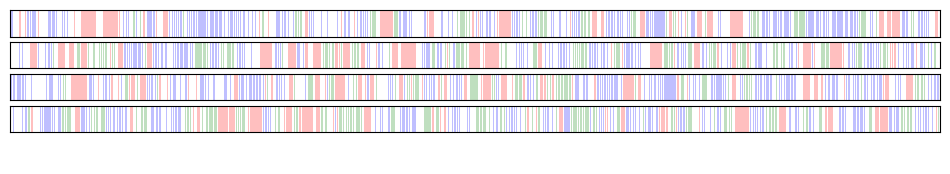

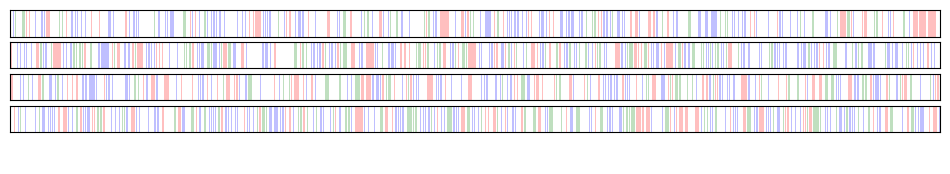

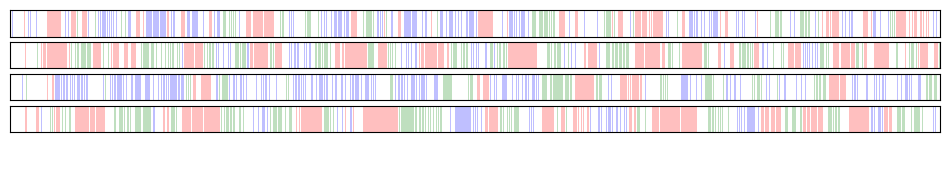

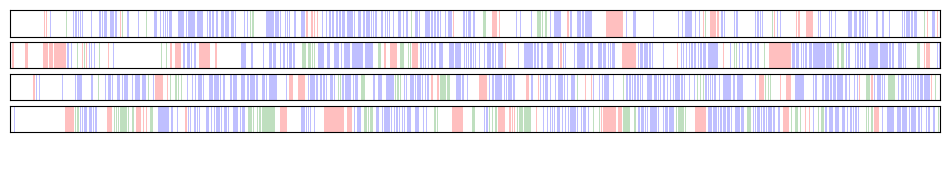

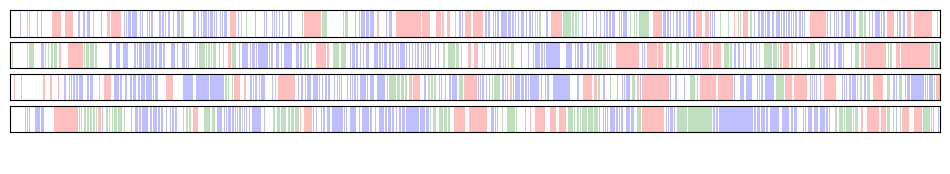

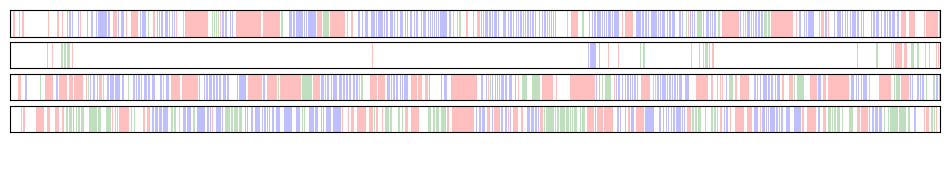

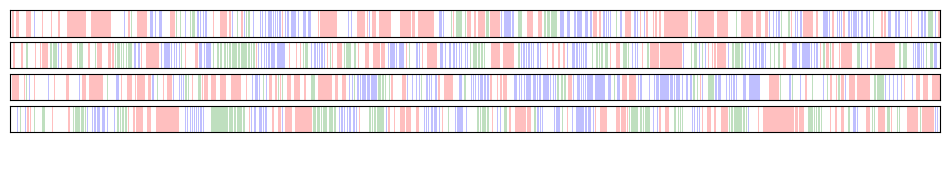

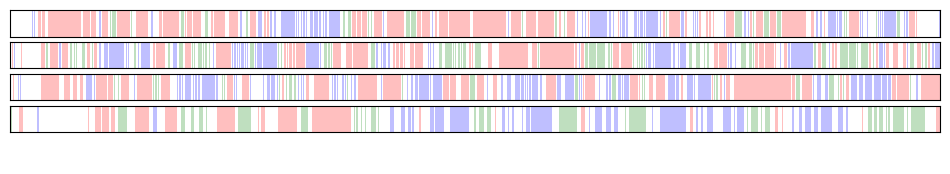

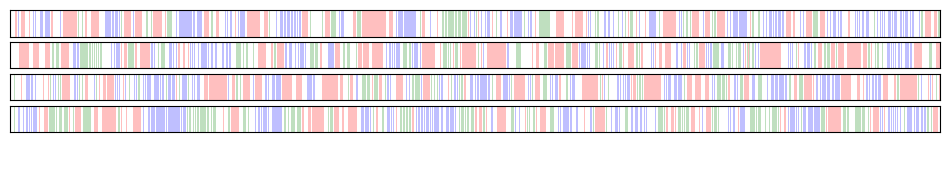

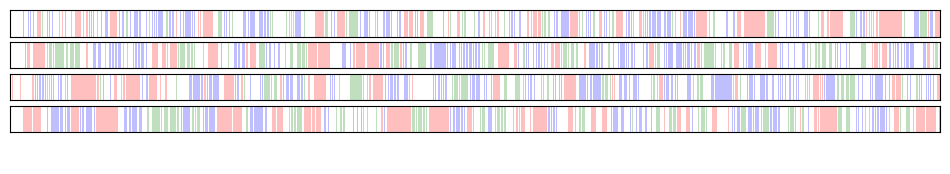

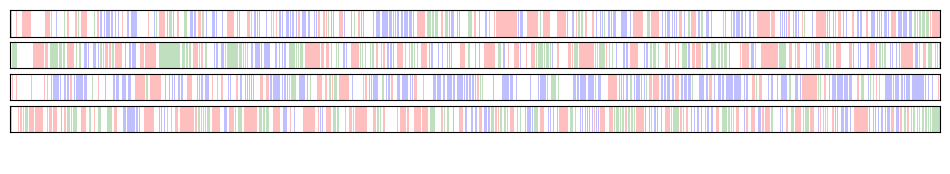

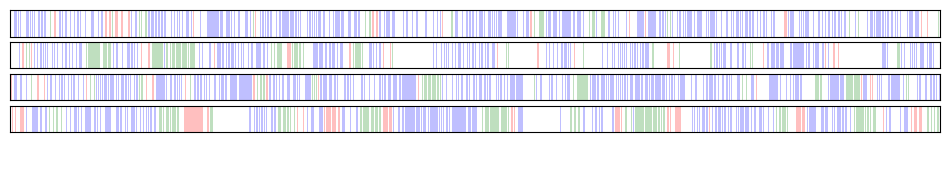

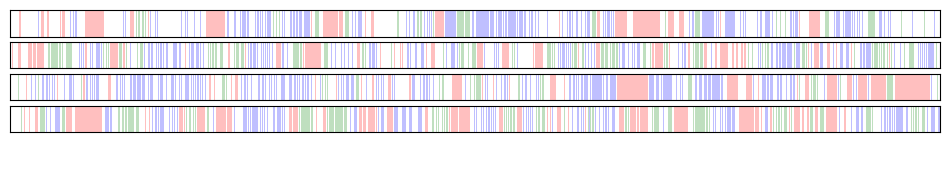

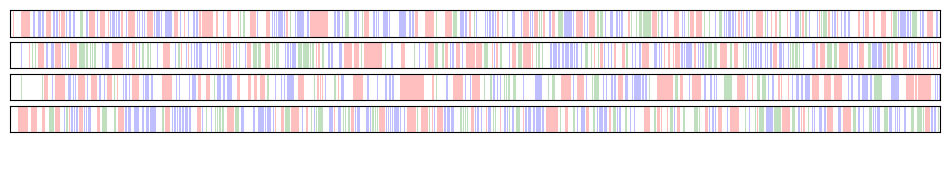

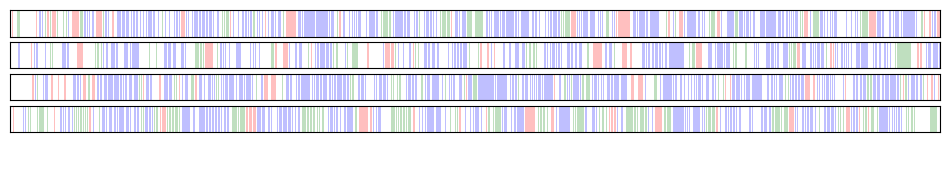

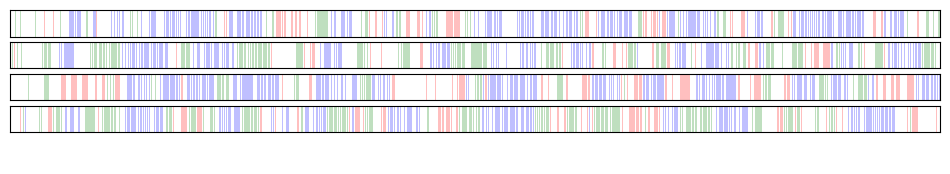

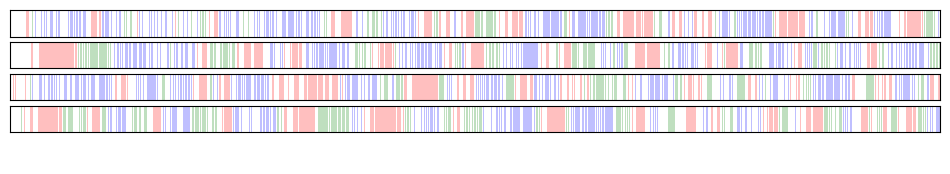

In [7]:
statistics = {}

for participant, _datasets in tqdm(datasets.items()):
    # plot time spent gazeing at each task (one plot per experiment)
    fig, axes = new_figure()
    stats = statistics[participant] = dict({k:{} for k in _datasets.keys()})
    for (experiment, dataset), ax in zip(_datasets.items(), axes):
        df = get_eyetracking_data(dataset) # contains eyetracking data for the given experiment
        #stats[experiment]['data'] = df
        start_time, finish_time = df.timestamp.to_numpy()[0].item(), df.timestamp.to_numpy()[-1].item()
        stats[experiment]['start_time'], stats[experiment]['finish_time'] = start_time, finish_time
        stats[experiment]['duration'] = finish_time - start_time
        ax.set_xlim(start_time, finish_time)
        gaze = df.gaze.to_numpy().astype(int)
        stats[experiment][f'gaze@nothing'] = 0 # setup
        
        # COMPUTE STATISTICS: time spent gazing at each task.
        for task, window_properties in ALL_WINDOW_PROPERTIES.items():
            # for each eyetracking event, check if the participant is looking at the given task
            intaskbox = in_box(df.x.to_numpy(), df.y.to_numpy(), window_properties['position'], window_properties['size']) # 
            gazeintaskbox = np.logical_and(intaskbox, gaze)
            result = compute_time_intervals(gazeintaskbox, df.timestamp.to_numpy(), start_time, finish_time)
            plot_intervals(result.intervals, ax, color=window_properties['color'])
            stats[experiment][f'gaze@{task}'] = result.proportion # individual stats for each task
            stats[experiment][f'gaze@nothing'] += result.proportion # total gaze at each
        result = compute_time_intervals(gaze, df.timestamp.to_numpy(), start_time, finish_time)
        stats[experiment][f'gaze@any'] = result.proportion
        stats[experiment][f'gaze@nothing'] = result.proportion - stats[experiment][f'gaze@nothing']
        
        # COMPUTE STATISTICS: total number of fixations TODO
        stats[experiment]['total_gaze_events'] = int((1-gaze).sum().item())
        stats[experiment]['total_succade_events'] = int(gaze.sum().item())
        stats[experiment]['total_eye_events'] = gaze.shape[0]
        # number of groups of consequtive gaze events
        stats[experiment]['total_gaze'] = compute_num_groups_of_ones(gaze)
        
        # COMPUTE STATISTICS: number of times switched between tasks
        in_task = [in_box(df.x.to_numpy(), df.y.to_numpy(), props['position'], props['size']) for props in ALL_WINDOW_PROPERTIES.values()]
        in_task = [in_task[i].astype(int)*(i+1) for i in range(len(in_task))]
        in_task = reduce(lambda a,b:a+b, in_task)
        in_task = in_task[in_task > 0] # ignore the times where we go out then in the same task
        stats[experiment]['task_switch'] = (in_task[:-1] != in_task[1:]).sum().item()
    plt.savefig(f"./results/images/gaze/{participant}.png", bbox_inches="tight", dpi=200)  

pprint(statistics)
import json
json.dump(statistics, open("./results/eye_tracking_statistics.json", 'w'))